# **Lab 8.1 Transfer Learning & Multitask Learning**

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.models import vgg16, VGG16_Weights
from torch.utils.tensorboard import SummaryWriter
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader,Subset,Dataset,random_split
from PIL import Image


import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
from sklearn.metrics import classification_report, confusion_matrix

Complete the `MultiLanguageHandwrittenDataset` class below. It should return:
- `image`: the image data
- `label`: the digit label (0-9)
- `language`: the language (Thai or English)


In [2]:
### START CODE HERE ###
class MultiLanguageHandwrittenDataset(Dataset):
    def __init__(self, root_dirs, languages, transforms=None):
        self.root_dirs = root_dirs
        self.languages = languages
        self.transform = transforms
        self.languages_to_idx = {lang: idx for idx, lang in enumerate(languages)}
        self.samples = []
        for root_dir, language in zip(self.root_dirs, self.languages):
            for subdir in os.scandir(root_dir):
                if subdir.is_dir():
                    label = int(subdir.name)
                    for file in os.scandir(subdir.path):
                        if file.is_file():
                            self.samples.append((file.path, label, language))

    def __len__(self):
        return len(self.samples)
    

    def __getitem__(self, idx):
        image_path, label, language = self.samples[idx]
        image = Image.open(image_path).convert("RGB")
        # print(image.size)
        if self.transform:
            image = self.transform(image)
        # check if the image have white bg if yes then invert the image to have black bg
        mean_i = torch.mean(image)
        if mean_i > 0.5:
            image = 1 - image
        language_idx = self.languages_to_idx[language]  # Convert language to an index
        return image, label, language_idx
### END CODE HERE ###

use you `MultiLanguageHandwrittenDataset` here and display the first batch
<details>
<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The output should resemble this, but not be identical

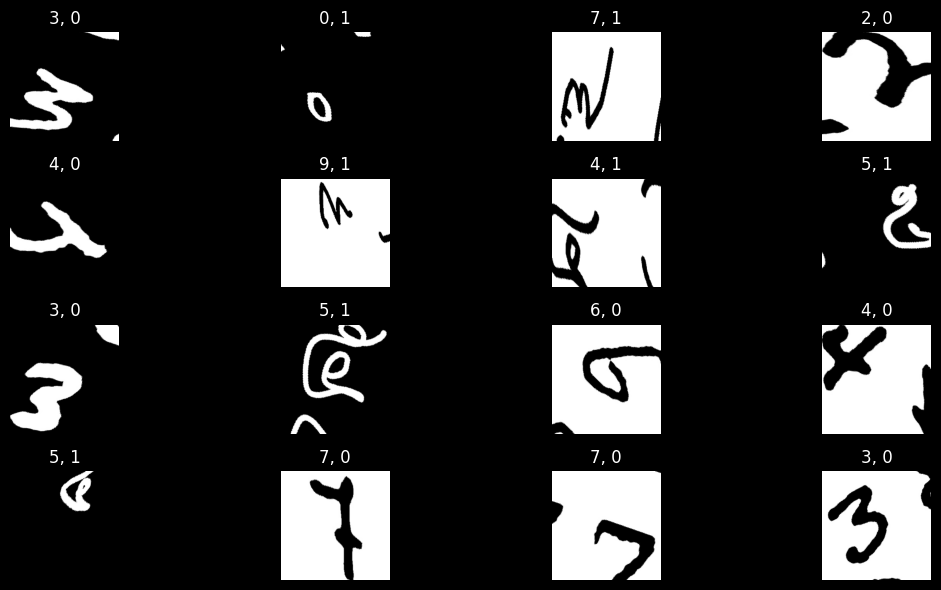

</details>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

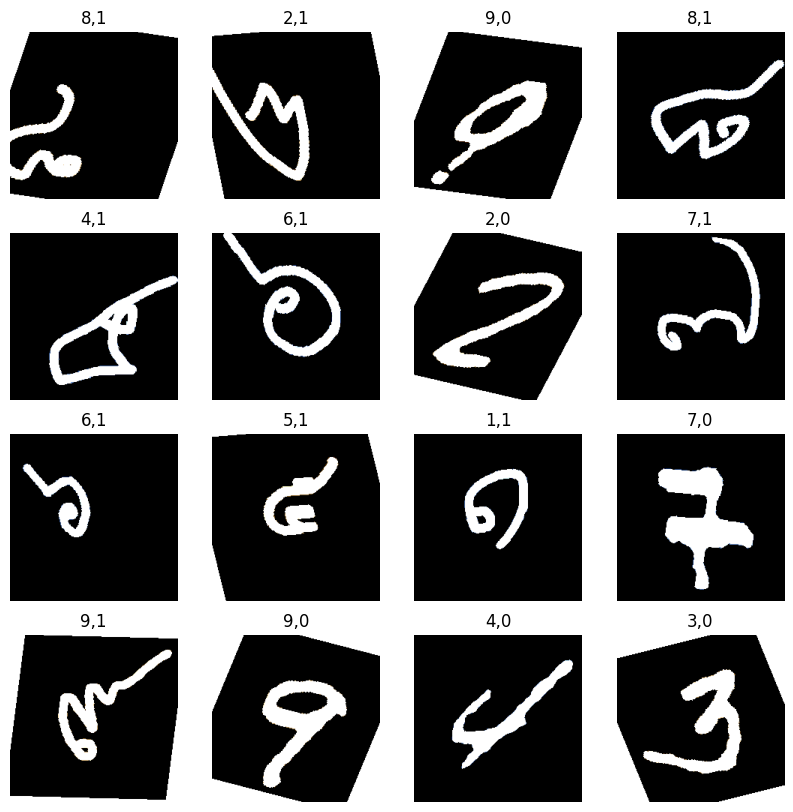

In [4]:
### START CODE HERE ###
root_dirs = [
    'data/data/data/eng-handwritten-dataset' ,
    'data/data/data/thai-handwritten-dataset'
]
languages = ['English', 'Thai']

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.RandomAffine(degrees=15, translate=(0.02,0.02), scale=(0.9,1.1), shear=15)
])

dataset = MultiLanguageHandwrittenDataset(root_dirs=root_dirs, languages=languages, transforms=transform)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

batch, labels, languages = next(iter(dataloader))
def imshow_grid(images,labels,languages):
    fig, axes = plt.subplots(4, 4, figsize=(10,10))
    axes = axes.ravel()
    for i, _ in enumerate(images):
        image = images[i].permute(1,2,0).numpy()
        axes[i].imshow(image)
        axes[i].set_title(f"{labels[i]},{languages[i]}")
        axes[i].axis('off')
    plt.show()
    
imshow_grid(batch,labels,languages)
### END CODE HERE ###


## Transfer learning

Complete the `customVGG16` class below, which can create a pretrained VGG16 model and customize the number of fully connected (FC) layers. It also allows adding new convolutional layers and unfreezing pretrained layers based on their index.

In [5]:
### START CODE HERE ###
class customVGG16(nn.Module):
    def __init__(self,add_feat_dims=None,h_dims=None,num_classes=10,input_size=(1,28,28),trainable_layers_idx=None):
        super(customVGG16, self).__init__()
        # load pre-trained model
        self.vgg16 = models.vgg16(pretrained=True)
        # freeze all layers
        for param in self.vgg16.features[:].parameters():
            param.requires_grad = False
        # unfreeze the last 3 layers
        for param in self.vgg16.classifier.parameters():
            param.requires_grad = True
        # unfreeze the layers in trainable_layers_idx
        if trainable_layers_idx is not None:
            # print(len(self.vgg16.features))
            for idx in trainable_layers_idx:
                for param in self.vgg16.features[idx].parameters():
                    param.requires_grad = True
        self.add_feat_dims = add_feat_dims
        if self.add_feat_dims is not None:
            features = []
            for i,out_ch in enumerate(self.add_feat_dims):
                if i == 0 :
                    features.append(nn.Conv2d(self.vgg16.features[-3].out_channels, out_ch, kernel_size=3,padding="same"))
                else:
                    features.append(nn.Conv2d(self.add_feat_dims[i-1], out_ch, kernel_size=3,padding="same"))
                features.append(nn.ReLU(inplace=True))
            self.vgg16.features = nn.Sequential(self.vgg16.features, *features,)
        self.h_dims = h_dims
        if self.h_dims is not None:
            layers = []
            for i,h_dim in enumerate(self.h_dims):
                if i == 0:
                    layers.append(nn.Linear(self._get_input_size_fc(input_size), h_dim))
                else:
                    layers.append(nn.Linear(self.h_dims[i-1], h_dim))
                layers.append(nn.Dropout(0.4,inplace=False))
                layers.append(nn.ReLU())
            self.vgg16.classifier = nn.Sequential(*layers, nn.Linear(self.h_dims[-1], num_classes)) # เปลี่ยน classifier ทั้งหมดจาก pretrained model เก่าเป็นของเรา
        else:
            self.vgg16.classifier = nn.Linear(self._get_input_size_fc(input_size), num_classes)       
            
        # print(self.vgg16)
        # print(len(self.vgg16.features))


    def _get_input_size_fc(self, input_shape):
        with torch.no_grad():
            x = torch.zeros(1, *input_shape)
            x = self.vgg16.features(x)
            x = self.vgg16.avgpool(x)
            x = torch.flatten(x[0])
            return x.size(0)
    
    def forward(self, x):
        x = self.vgg16.features(x)
        x = self.vgg16.avgpool(x)
        x = x.view(x.size(0), -1) # เหมือนกับ torch.flatten(x, 1)
        x = self.vgg16.classifier(x)
        
        return x
### END CODE HERE ###


Example usage
```
trainable_layers_idx = [-1,-2,-3,-4,-5]
model = customVGG16(add_feat_dims=[512],h_dims=[512,256,256],input_size=(3,224,224),trainable_layers_idx=trainable_layers_idx)

```


Complete the `train` function below, which logs Loss/train, Accuracy/train, Loss/test, and Accuracy/test to [TensorBoard](https://pytorch.org/docs/stable/tensorboard.html).Then, complete the evaluate_task function, which prints the classification report and plots the confusion matrix

In [6]:
### START CODE HERE ###
import seaborn as sns

def train(model, opt, loss_fn, train_loader, val_loader, epochs=10, writer=None, checkpoint_path=None, device='cpu', task='digit'):
    print("🤖 Training on", device)
    model = model.to(device)
    
    for epoch in range(epochs):
        # Train the model
        model.train()
        total_train_loss = 0.0
        total_train_correct = 0
        total_train_samples = 0
        train_bar = tqdm(train_loader, desc=f'🚀 Training Epoch [{epoch+1}/{epochs}]', unit='batch')
        for images, labels, languages in train_bar:
            images, labels, languages = images.to(device), labels.to(device) ,languages.to(device)

            opt.zero_grad()
            
            outputs = model(images)
            
            if task.lower() == 'language':
                loss = loss_fn(outputs, languages)
            else:
                # print("digit")
                loss = loss_fn(outputs, labels)
            loss.backward()
            opt.step()
            
            total_train_loss += loss.item()

            
            # Calculate accuracy
            _, predicted = torch.max(outputs, dim=1)
            if task.lower() == 'language':
                total_train_correct += (predicted == languages).sum().item()
            else:
                # print(f"{predicted} \n{labels}\n\n")
                total_train_correct += (predicted == labels).sum().item()
            # print(outputs)
            total_train_samples += labels.size(0)
            # print(f"{total_train_correct}/{total_train_samples}",end="\r")
            train_bar.set_postfix(loss=loss.item(), accuracy=f"{(total_train_correct/total_train_samples):.4f}")
        
        avg_train_loss = total_train_loss / len(train_loader)
        train_accuracy = total_train_correct / total_train_samples
        
        # Validate the model
        model.eval()
        total_val_loss = 0.0
        total_val_correct = 0
        total_val_samples = 0
        with torch.no_grad():
            val_bar = tqdm(val_loader, desc='📄 Validating', unit='batch')
            for images, labels, languages in val_bar:
                images, labels ,languages= images.to(device), labels.to(device) ,languages.to(device)
                
                outputs = model(images)
                
                if task.lower() == 'language':
                    # Calculate loss
                    loss = loss_fn(outputs, languages)
                elif task.lower() == 'digit':
                    loss = loss_fn(outputs, labels)
                total_val_loss += loss.item()

                # Calculate accuracy
                _, predicted = torch.max(outputs, dim=1)
                
                if task.lower() == 'language':
                    total_val_correct += (predicted == languages).sum().item()
                    total_val_samples += languages.size(0)
                else:
                    total_val_correct += (predicted == labels).sum().item()
                    total_val_samples += labels.size(0)
                

                val_bar.set_postfix(loss=f"{loss.item():.4f}", accuracy=f"{(total_val_correct/total_val_samples):.4f}")
        
        avg_val_loss = total_val_loss / len(val_loader)
        avg_train_loss = total_train_loss / len(train_loader)
        train_accuracy = total_train_correct / len(train_loader.dataset)
        val_accuracy = total_val_correct / len(val_loader.dataset)

        print(f"Summary:\n\tTrain Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
        print(f"\tVal Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")
        
        if writer:
            writer.add_scalar('Loss/Train', avg_train_loss, epoch)
            writer.add_scalar('Accuracy/Train', train_accuracy, epoch)
            writer.add_scalar('Loss/Val', avg_val_loss, epoch)
            writer.add_scalar('Accuracy/Val', val_accuracy, epoch)

    if checkpoint_path:
        torch.save(model.state_dict(), checkpoint_path)
        print(f"Saved Model at {checkpoint_path}")
    # Close the TensorBoard writer
    if writer:
        writer.close()


def test(model, loss_fn, test_loader, device='cpu',task='digit'):
    model.to(device)
    print("🔍 Testing on test set...")
    model.eval()
    total_test_loss = 0.0
    total_test_correct = 0
    total_test_samples = 0
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for images, labels, languages in tqdm(test_loader, desc='🔍 Testing', unit='batch'):
            images, labels ,languages= images.to(device), labels.to(device) ,languages.to(device)
            
            outputs = model(images)
                
            if task.lower() == 'language':
                loss = loss_fn(outputs, languages)
            elif task.lower() == 'digit':
                loss = loss_fn(outputs, labels)
                
            total_test_loss += loss.item()

            _, predicted = torch.max(outputs, dim=1)
            if task.lower() == 'language':
                total_test_correct += (predicted == languages).sum().item()
            else:
                total_test_correct += (predicted == labels).sum().item()
                    
            if task.lower() == 'language':
                total_test_samples += languages.size(0)
            else:
                total_test_samples += labels.size(0)

            if task.lower() == 'language':
                y_true.extend(languages.cpu().numpy())
            else:
                y_true.extend(labels.cpu().numpy())
                
            y_pred.extend(predicted.cpu().numpy())
    
    avg_test_loss = total_test_loss / len(test_loader)
    test_accuracy = total_test_correct / total_test_samples

    print(f"\nTest Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

    return y_true, y_pred


def evaluate_task(y_true:list, y_pred:list, task_name="Task"):
    # Print classification report
    print(f"{task_name} - Classification Report:")
    print(classification_report(y_true, y_pred,target_names=["Eng","Thai"] if task_name.lower() == 'language' else [str(i) for i in range(10)]))

    # Plot confusion matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{task_name} Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()


### END CODE HERE ###

### Transfer learning for Digit classification task
Declare the `customVGG16` model with custom layers of your choice. Then, split the dataset into training, validation, and test sets, and proceed to train the model.

In [7]:
### START CODE HERE ###
trainable_layers_idx = [-1,-2,-3,-4,-5]
model = customVGG16(add_feat_dims=[512],h_dims=[512,256,256],input_size=(3,224,224),trainable_layers_idx=trainable_layers_idx,num_classes=10)

train_dataset, val_dataset, test_dataset = random_split(dataset, [int(0.8*len(dataset)), int(0.1*len(dataset)), int(0.1*len(dataset))]) # แบ่งข้อมูลเป็น 80% train, 10% val, 10% test
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

writer = SummaryWriter(log_dir='logs/transfer_learning')
opt = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss()
train(model, opt, loss_fn, train_loader, val_loader, epochs=10, writer=writer, checkpoint_path='digit_model.pth', device='cuda' if torch.cuda.is_available() else 'cpu', task='digit')
model.load_state_dict(torch.load('digit_model.pth'))
y_true, y_pred = test(model, loss_fn, test_loader, device='cuda' if torch.cuda.is_available() else 'cpu')

### END CODE HERE ###


c:\Users\bluep\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\bluep\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


🤖 Training on cpu


🚀 Training Epoch [1/10]:  21%|██        | 37/175 [04:42<17:33,  7.64s/batch, accuracy=0.1166, loss=2.26]


KeyboardInterrupt: 

In [22]:
### START CODE HERE ###
model.load_state_dict(torch.load('digit_customvgg16_model.pth'))
y_true, y_pred = test(model, loss_fn, test_loader, device='cuda' if torch.cuda.is_available() else 'cpu')
### END CODE HERE ###

C:\Users\kidsa\AppData\Local\Temp\ipykernel_21796\2478248993.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('digit_model.pth'))


🔍 Testing on test set...


🔍 Testing: 100%|██████████| 22/22 [00:05<00:00,  4.24batch/s]


Test Loss: 0.1331, Test Accuracy: 0.9600


use `evaluate_task` to evlauate you model1 here.
<details>
<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The output should resemble this, but not be identical

```
Digit - Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.92      0.84        26
           1       0.75      0.94      0.83        32
           2       0.66      0.54      0.59        39
           3       0.76      0.54      0.63        35
           4       0.68      0.53      0.60        47
           5       0.52      0.42      0.47        33
           6       0.59      0.88      0.71        33
           7       0.46      0.59      0.52        27
           8       0.70      0.65      0.67        43
           9       0.85      0.83      0.84        35

    accuracy                           0.67       350
   macro avg       0.67      0.68      0.67       350
weighted avg       0.68      0.67      0.67       350

```

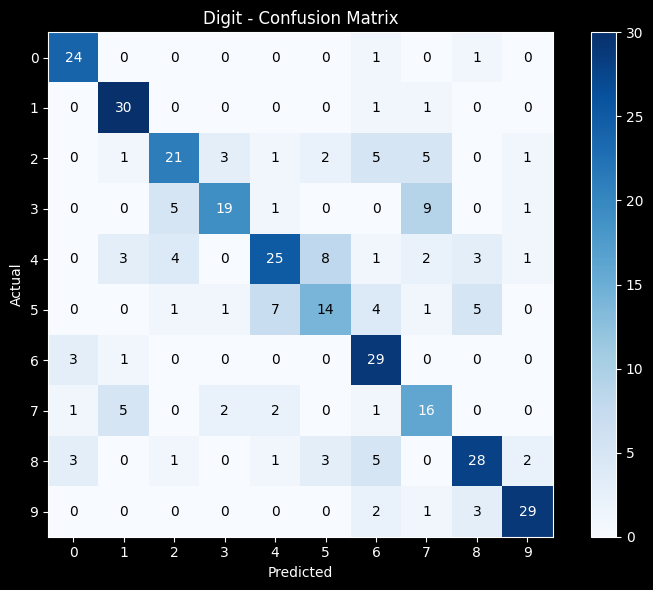

</details>

Digit - Classification Report:
              precision    recall  f1-score   support

           0       0.89      1.00      0.94        34
           1       1.00      1.00      1.00        22
           2       1.00      0.94      0.97        51
           3       0.95      0.95      0.95        41
           4       0.98      1.00      0.99        40
           5       1.00      1.00      1.00        39
           6       0.85      0.92      0.88        25
           7       0.95      0.97      0.96        36
           8       1.00      0.89      0.94        27
           9       0.97      0.91      0.94        35

    accuracy                           0.96       350
   macro avg       0.96      0.96      0.96       350
weighted avg       0.96      0.96      0.96       350



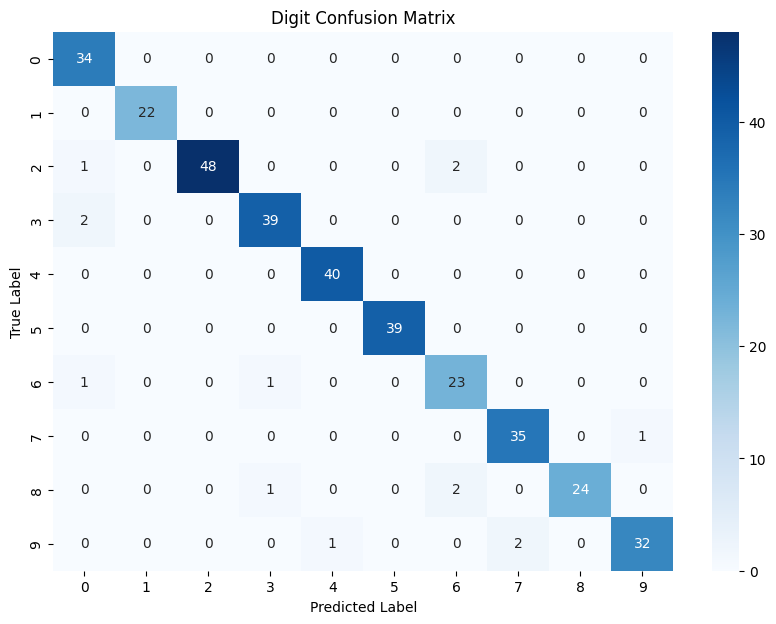

In [23]:
### START CODE HERE ###
evaluate_task(y_true, y_pred, task_name="Digit")
### END CODE HERE ###


### Transfer learning for Language classification task
Declare a NEW `customVGG16` model with custom layers of your choice.

In [24]:
### START CODE HERE ###
trainable_layers_idx = [-1,-2,-3,-4,-5]
model2 = customVGG16(add_feat_dims=[512],h_dims=[256],input_size=(3,224,224),trainable_layers_idx=trainable_layers_idx,num_classes=2)

train_dataset, val_dataset, test_dataset = random_split(dataset, [int(0.8*len(dataset)), int(0.1*len(dataset)), int(0.1*len(dataset))]) # แบ่งข้อมูลเป็น 80% train, 10% val, 10% test

writer = SummaryWriter(log_dir='logs/transfer_learning')
opt = torch.optim.Adam(model2.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()
train(model2, opt, loss_fn, train_loader, val_loader, epochs=10, writer=writer, checkpoint_path='lang_model.pth', device='cuda' if torch.cuda.is_available() else 'cpu', task='language')
### END CODE HERE ###


c:\Users\kidsa\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\kidsa\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


🤖 Training on cuda


📄 Validating: 100%|██████████| 22/22 [00:05<00:00,  4.38batch/s, accuracy=0.9286, loss=0.3049]


Summary:
	Train Loss: 0.1874, Train Accuracy: 0.9479
	Val Loss: 0.2015, Val Accuracy: 0.9286


📄 Validating: 100%|██████████| 22/22 [00:04<00:00,  4.43batch/s, accuracy=0.9943, loss=0.0036]


Summary:
	Train Loss: 0.0376, Train Accuracy: 0.9900
	Val Loss: 0.0099, Val Accuracy: 0.9943


📄 Validating: 100%|██████████| 22/22 [00:04<00:00,  4.44batch/s, accuracy=0.9914, loss=0.0000]


Summary:
	Train Loss: 0.0332, Train Accuracy: 0.9896
	Val Loss: 0.0381, Val Accuracy: 0.9914


📄 Validating: 100%|██████████| 22/22 [00:04<00:00,  4.41batch/s, accuracy=1.0000, loss=0.0396]


Summary:
	Train Loss: 0.0750, Train Accuracy: 0.9854
	Val Loss: 0.0046, Val Accuracy: 1.0000


📄 Validating: 100%|██████████| 22/22 [00:05<00:00,  4.40batch/s, accuracy=0.9886, loss=0.0734]


Summary:
	Train Loss: 0.0295, Train Accuracy: 0.9911
	Val Loss: 0.0292, Val Accuracy: 0.9886


📄 Validating: 100%|██████████| 22/22 [00:04<00:00,  4.43batch/s, accuracy=0.9914, loss=0.0000]


Summary:
	Train Loss: 0.0226, Train Accuracy: 0.9946
	Val Loss: 0.0153, Val Accuracy: 0.9914


📄 Validating: 100%|██████████| 22/22 [00:04<00:00,  4.41batch/s, accuracy=0.9943, loss=0.0000]


Summary:
	Train Loss: 0.0082, Train Accuracy: 0.9975
	Val Loss: 0.0063, Val Accuracy: 0.9943


📄 Validating: 100%|██████████| 22/22 [00:04<00:00,  4.45batch/s, accuracy=0.9943, loss=0.0016]


Summary:
	Train Loss: 0.0584, Train Accuracy: 0.9868
	Val Loss: 0.0062, Val Accuracy: 0.9943


📄 Validating: 100%|██████████| 22/22 [00:04<00:00,  4.44batch/s, accuracy=0.9971, loss=0.0028]


Summary:
	Train Loss: 0.0426, Train Accuracy: 0.9904
	Val Loss: 0.0046, Val Accuracy: 0.9971


📄 Validating: 100%|██████████| 22/22 [00:04<00:00,  4.44batch/s, accuracy=0.9971, loss=0.0645]

Summary:
	Train Loss: 0.0511, Train Accuracy: 0.9911
	Val Loss: 0.0131, Val Accuracy: 0.9971
Saved Model at lang_model.pth


use `evaluate_task` to evlauate you model2 here.
<details>
<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The output should resemble this, but not be identical

```
Language - Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       175
           1       0.99      0.93      0.96       175

    accuracy                           0.96       350
   macro avg       0.96      0.96      0.96       350
weighted avg       0.96      0.96      0.96       350

```

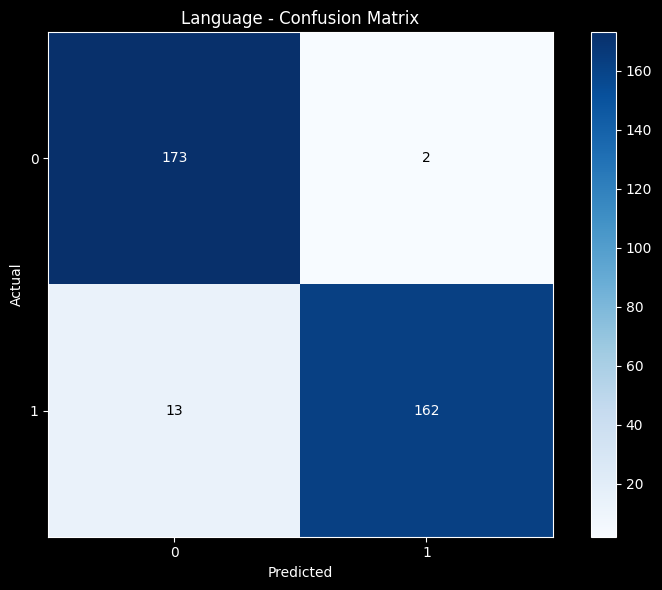

</details>

C:\Users\kidsa\AppData\Local\Temp\ipykernel_21796\3186783510.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model2.load_state_dict(torch.load('lang_model.pth'))


🔍 Testing on test set...


🔍 Testing: 100%|██████████| 22/22 [00:05<00:00,  4.22batch/s]


Test Loss: 0.0308, Test Accuracy: 0.9971
language - Classification Report:
              precision    recall  f1-score   support

         Eng       0.99      1.00      1.00       174
        Thai       1.00      0.99      1.00       176

    accuracy                           1.00       350
   macro avg       1.00      1.00      1.00       350
weighted avg       1.00      1.00      1.00       350



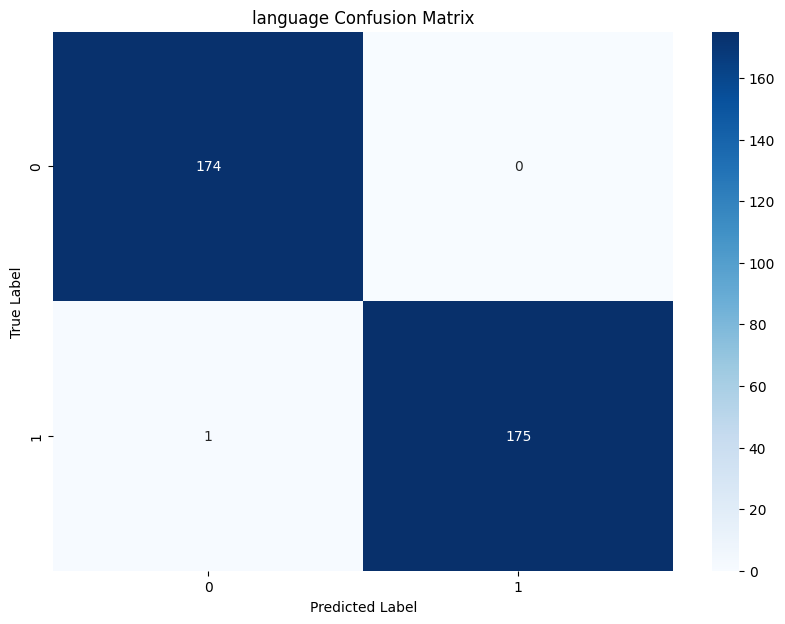

In [25]:
### START CODE HERE ###
model2.load_state_dict(torch.load('lang_model.pth'))
y_true, y_pred = test(model2, loss_fn, test_loader, device='cuda' if torch.cuda.is_available() else 'cpu',task='language')
evaluate_task(y_true, y_pred, task_name="language")
### END CODE HERE ###

---

## Multitask learning

Complete the `customVGG16_multitask` class below, which can create a pretrained VGG16 model and customize the number of fully connected (FC) layers. It also allows adding new convolutional layers and unfreezing pretrained layers based on their index. Additionally, it allows branching the model into two heads for multitask learning, where one head handles digit classification, and the other handles language classification

In [26]:
class customVGG16_multitask(nn.Module):
    def __init__(self,add_feat_dims=None,h_dims=None,input_size=(1,28,28),trainable_layers_idx=None):
        super(customVGG16_multitask, self).__init__()
        # load pre-trained model
        self.vgg16 = models.vgg16(pretrained=True)
        # freeze all layers
        for param in self.vgg16.features[:].parameters():
            param.requires_grad = False
        # unfreeze the last 3 layers
        for param in self.vgg16.classifier.parameters():
            param.requires_grad = True
        # unfreeze the layers in trainable_layers_idx
        if trainable_layers_idx is not None:
            # print(len(self.vgg16.features))
            for idx in trainable_layers_idx:
                for param in self.vgg16.features[idx].parameters():
                    param.requires_grad = True
        self.add_feat_dims = add_feat_dims
        if self.add_feat_dims is not None:
            features = []
            for i,out_ch in enumerate(self.add_feat_dims):
                if i == 0 :
                    features.append(nn.Conv2d(self.vgg16.features[-3].out_channels, out_ch, kernel_size=3,padding="same"))
                else:
                    features.append(nn.Conv2d(self.add_feat_dims[i-1], out_ch, kernel_size=3,padding="same"))
                features.append(nn.ReLU(inplace=True))
            self.vgg16.features = nn.Sequential(self.vgg16.features, *features,)
        self.h_dims = h_dims  
        input_size_fc1 = self._get_input_size_fc(input_size)
        if h_dims is not None:
            input_size_fc1 = self._get_input_size_fc(input_size)
            layers = []
            for i,h_dim in enumerate(h_dims):
                if i == 0:
                    layers.append(nn.Linear(input_size_fc1, h_dim))
                else:
                    layers.append(nn.Linear(h_dims[i-1], h_dim))
                layers.append(nn.Dropout(0.4,inplace=False))
                layers.append(nn.ReLU())
            self.vgg16.digit = nn.Sequential(*layers, nn.Linear(h_dims[-1], 10))
            self.vgg16.lang = nn.Sequential(*layers, nn.Linear(h_dims[-1], 2))
        else:
            self.vgg16.digit = nn.Linear(input_size_fc1, 10)
            self.vgg16.lang = nn.Linear(input_size_fc1, 2)
            
        
        # print(self.vgg16)
        # print(len(self.vgg16.features))


    def _get_input_size_fc(self, input_shape):
        with torch.no_grad():
            x = torch.zeros(1, *input_shape)
            x = self.vgg16.features(x)
            x = self.vgg16.avgpool(x)
            x = torch.flatten(x[0])
            return x.size(0)
    
    def forward(self, x):
        x = self.vgg16.features(x)
        x = self.vgg16.avgpool(x)
        x = x.view(x.size(0), -1) # เหมือนกับ torch.flatten(x, 1)
        out1 = self.vgg16.digit(x)
        out2 = self.vgg16.lang(x)
        # print(out1.size(),out2.size())
        return out1,out2

Complete the `train_multi` function below, which train multitask model and  logs Loss/train, Accuracy/train, Loss/test, and Accuracy/test to [TensorBoard](https://pytorch.org/docs/stable/tensorboard.html).

In [27]:
def train_multi(model, opt, loss_fn, train_loader, val_loader, epochs=10, writer=None, checkpoint_path=None, device='cpu'):
    print("🤖 Training on", device)
    model = model.to(device)
    
    best_val_loss = float('inf')
    
    for epoch in range(epochs):
        # Train the model
        model.train()
        total_train_loss = 0.0
        total_digit_train_loss = 0.0
        total_lang_train_loss = 0.0
        correct_digit_train = 0
        correct_lang_train = 0
        total_train = 0
        
        train_bar = tqdm(train_loader, desc=f'🚀 Training Epoch [{epoch+1}/{epochs}]', unit='batch')
        for images, labels, languages in train_bar:
            images, labels, languages = images.to(device), labels.to(device), languages.to(device)

            # Zero gradient
            opt.zero_grad()
            
            # Forward pass
            output_digit, output_lang = model(images)
            
            # Calculate loss
            loss_digit = loss_fn(output_digit, labels)
            loss_lang = loss_fn(output_lang, languages)
            loss = (loss_digit * 0.7) + (loss_lang * 0.3)
            total_train_loss += loss.item()
            total_digit_train_loss += loss_digit.item()
            total_lang_train_loss += loss_lang.item()
            
            # Backward and optimize
            loss.backward()
            opt.step()

            # Calculate accuracy
            _, pred_digit = torch.max(output_digit, dim=1)
            _, pred_lang = torch.max(output_lang, dim=1)
            correct_digit_train += (pred_digit == labels).sum().item()
            correct_lang_train += (pred_lang == languages).sum().item()
            total_train += labels.size(0)

            train_bar.set_postfix(
                digit_loss=loss_digit.item(), 
                lang_loss=loss_lang.item(), 
                digit_accuracy=f"{(correct_digit_train/total_train):.4f}", 
                lang_accuracy=f"{(correct_lang_train/total_train):.4f}"
            )
        
        avg_train_loss = total_train_loss / len(train_loader)
        avg_digit_train_loss = total_digit_train_loss / len(train_loader)
        avg_lang_train_loss = total_lang_train_loss / len(train_loader)
        acc_digit_train = correct_digit_train / total_train
        acc_lang_train = correct_lang_train / total_train
        avg_train_acc = (acc_digit_train + acc_lang_train) / 2
        
        # TensorBoard Logging (Training)
        if writer:
            writer.add_scalar('Loss/Train', avg_train_loss, epoch)
            writer.add_scalar('Loss/digit_train', avg_digit_train_loss, epoch)
            writer.add_scalar('Loss/lang_train', avg_lang_train_loss, epoch)
            writer.add_scalar('Accuracy/digit_train', acc_digit_train, epoch)
            writer.add_scalar('Accuracy/lang_train', acc_lang_train, epoch)
            writer.add_scalar('Accuracy/avg_train_accuracy', avg_train_acc, epoch)
        
        # Validate the model
        model.eval()
        total_val_loss = 0.0
        total_digit_val_loss = 0.0
        total_lang_val_loss = 0.0
        correct_digit_val = 0
        correct_lang_val = 0
        total_val = 0
        
        with torch.no_grad():
            val_bar = tqdm(val_loader, desc=f'📄 Validating Epoch [{epoch+1}/{epochs}]', unit='batch')
            for images, labels, languages in val_bar:
                images, labels, languages = images.to(device), labels.to(device), languages.to(device)
                
                # Forward pass
                output_digit, output_lang = model(images)
                
                # Calculate loss
                loss_digit = loss_fn(output_digit, labels)
                loss_lang = loss_fn(output_lang, languages)
                loss = (loss_digit * 0.7) + (loss_lang * 0.3)
                total_val_loss += loss.item()
                total_digit_val_loss += loss_digit.item()
                total_lang_val_loss += loss_lang.item()
                
                # Calculate accuracy
                _, pred_digit = torch.max(output_digit, dim=1)
                _, pred_lang = torch.max(output_lang, dim=1)
                correct_digit_val += (pred_digit == labels).sum().item()
                correct_lang_val += (pred_lang == languages).sum().item()
                total_val += labels.size(0)

                val_bar.set_postfix(
                    digit_loss=loss_digit.item(), 
                    lang_loss=loss_lang.item(), 
                    digit_accuracy=f"{(correct_digit_val/total_val):.4f}", 
                    lang_accuracy=f"{(correct_lang_val/total_val):.4f}"
                )
        
        avg_val_loss = total_val_loss / len(val_loader)
        avg_digit_val_loss = total_digit_val_loss / len(val_loader)
        avg_lang_val_loss = total_lang_val_loss / len(val_loader)
        acc_digit_val = correct_digit_val / total_val
        acc_lang_val = correct_lang_val / total_val
        avg_val_acc = (acc_digit_val + acc_lang_val) / 2
        
        # TensorBoard Logging (Validation)
        if writer:
            writer.add_scalar('Loss/Val', avg_val_loss, epoch)
            writer.add_scalar('Loss/digit_val', avg_digit_val_loss, epoch)
            writer.add_scalar('Loss/lang_val', avg_lang_val_loss, epoch)
            writer.add_scalar('Accuracy/digit_val', acc_digit_val, epoch)
            writer.add_scalar('Accuracy/lang_val', acc_lang_val, epoch)
            writer.add_scalar('Accuracy/avg_val_accuracy', avg_val_acc, epoch)
        
        # Save the best model based on validation loss
        if checkpoint_path and avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(model.state_dict(), f"best_{checkpoint_path}")
            print(f"Saved Best Model at Epoch {epoch+1} with Val Loss: {best_val_loss:.4f}")
    
    if checkpoint_path:
        torch.save(model.state_dict(), checkpoint_path)
        print(f"Saved Model at {checkpoint_path}")
    
    # Close the TensorBoard writer
    if writer:
        writer.close()


In [28]:
### START CODE HERE ###
trainable_layers_idx = [-1,-2,-3,-4,-5]
model3 = customVGG16_multitask(add_feat_dims=[512],h_dims=[256],input_size=(3,224,224),trainable_layers_idx=trainable_layers_idx)

train_dataset, val_dataset, test_dataset = random_split(dataset, [int(0.8*len(dataset)), int(0.1*len(dataset)), int(0.1*len(dataset))]) # แบ่งข้อมูลเป็น 80% train, 10% val, 10% test

writer = SummaryWriter(log_dir='logs/multitask')
opt = torch.optim.Adam(model3.parameters(), lr=0.001)
loss_fn = nn.CrossEntropyLoss()
train_multi(model3, opt, loss_fn, train_loader, val_loader, epochs=20, writer=writer, checkpoint_path='multi.pth', device='cuda' if torch.cuda.is_available() else 'cpu')
### END CODE HERE ###


c:\Users\kidsa\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\kidsa\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


🤖 Training on cuda


📄 Validating Epoch [1/20]: 100%|██████████| 22/22 [00:04<00:00,  4.43batch/s, digit_accuracy=0.8543, digit_loss=0.224, lang_accuracy=0.9800, lang_loss=0.0705]  


Saved Best Model at Epoch 1 with Val Loss: 0.3359


📄 Validating Epoch [2/20]: 100%|██████████| 22/22 [00:04<00:00,  4.45batch/s, digit_accuracy=0.8457, digit_loss=0.126, lang_accuracy=0.9943, lang_loss=0.0943]  


Saved Best Model at Epoch 2 with Val Loss: 0.3253


📄 Validating Epoch [3/20]: 100%|██████████| 22/22 [00:04<00:00,  4.43batch/s, digit_accuracy=0.8800, digit_loss=0.68, lang_accuracy=1.0000, lang_loss=0.00017]  


Saved Best Model at Epoch 3 with Val Loss: 0.2885


📄 Validating Epoch [4/20]: 100%|██████████| 22/22 [00:04<00:00,  4.41batch/s, digit_accuracy=0.8714, digit_loss=0.395, lang_accuracy=0.9857, lang_loss=0.00898]  


Saved Best Model at Epoch 4 with Val Loss: 0.2400


📄 Validating Epoch [6/20]: 100%|██████████| 22/22 [00:04<00:00,  4.45batch/s, digit_accuracy=0.9143, digit_loss=0.0945, lang_accuracy=0.9971, lang_loss=5.56e-5] 


Saved Best Model at Epoch 6 with Val Loss: 0.1647


📄 Validating Epoch [7/20]: 100%|██████████| 22/22 [00:04<00:00,  4.44batch/s, digit_accuracy=0.9514, digit_loss=0.0525, lang_accuracy=0.9971, lang_loss=0.00018] 


Saved Best Model at Epoch 7 with Val Loss: 0.1357


📄 Validating Epoch [8/20]: 100%|██████████| 22/22 [00:04<00:00,  4.42batch/s, digit_accuracy=0.9457, digit_loss=0.0829, lang_accuracy=0.9943, lang_loss=1.09e-6] 


Saved Best Model at Epoch 8 with Val Loss: 0.1156


📄 Validating Epoch [20/20]: 100%|██████████| 22/22 [00:04<00:00,  4.41batch/s, digit_accuracy=0.9314, digit_loss=0.0254, lang_accuracy=1.0000, lang_loss=0.00013]  


Saved Model at multi.pth


use `evaluate_task` to evlauate you model here.
<details>
<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The output should resemble this, but not be identical

```
Digit - Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.89      0.86        35
           1       0.81      0.91      0.85        32
           2       0.76      0.55      0.64        40
           3       0.53      0.66      0.58        32
           4       0.54      0.29      0.38        24
           5       0.51      0.57      0.54        37
           6       0.68      0.72      0.70        29
           7       0.60      0.71      0.65        34
           8       0.62      0.71      0.66        48
           9       0.68      0.49      0.57        39

    accuracy                           0.65       350
   macro avg       0.66      0.65      0.64       350
weighted avg       0.66      0.65      0.65       350

```

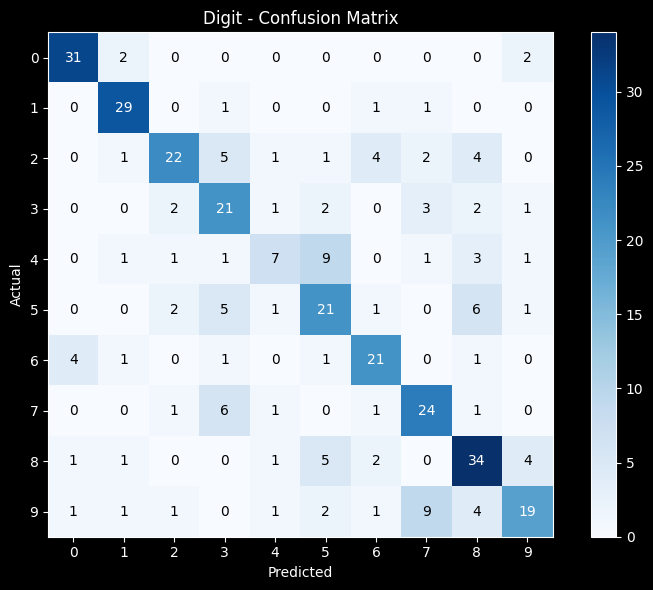

```
Language - Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       172
           1       0.98      0.98      0.98       178

    accuracy                           0.98       350
   macro avg       0.98      0.98      0.98       350
weighted avg       0.98      0.98      0.98       350
```

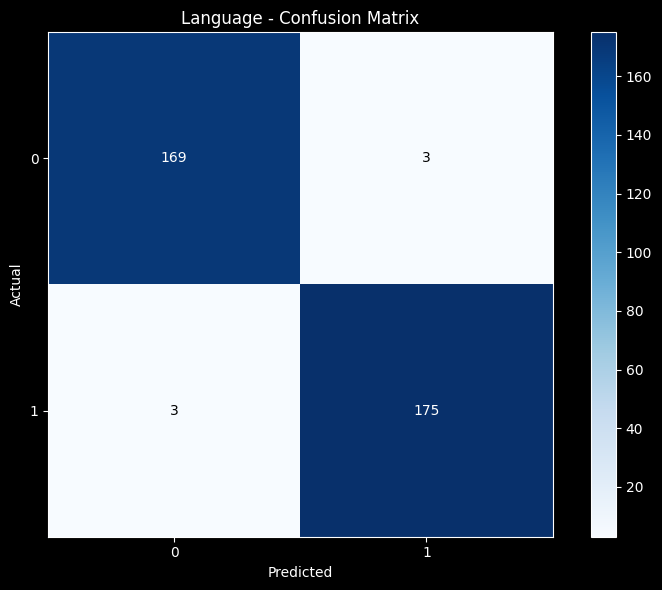

</details>

C:\Users\kidsa\AppData\Local\Temp\ipykernel_21796\1426360563.py:61: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model3.load_state_dict(torch.load('multi.pth'))


🔍 Testing on test set...


🔍 Testing: 100%|██████████| 22/22 [00:04<00:00,  4.40batch/s]



Test Digit Loss: 0.2181, Digit Accuracy: 0.9571
Test Language Loss: 0.0042, Language Accuracy: 0.9971
Digit - Classification Report:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99        34
           1       1.00      1.00      1.00        22
           2       1.00      0.96      0.98        51
           3       0.91      0.98      0.94        41
           4       0.97      0.95      0.96        40
           5       1.00      0.97      0.99        39
           6       1.00      0.96      0.98        25
           7       1.00      0.89      0.94        36
           8       0.92      0.85      0.88        27
           9       0.83      1.00      0.91        35

    accuracy                           0.96       350
   macro avg       0.96      0.96      0.96       350
weighted avg       0.96      0.96      0.96       350



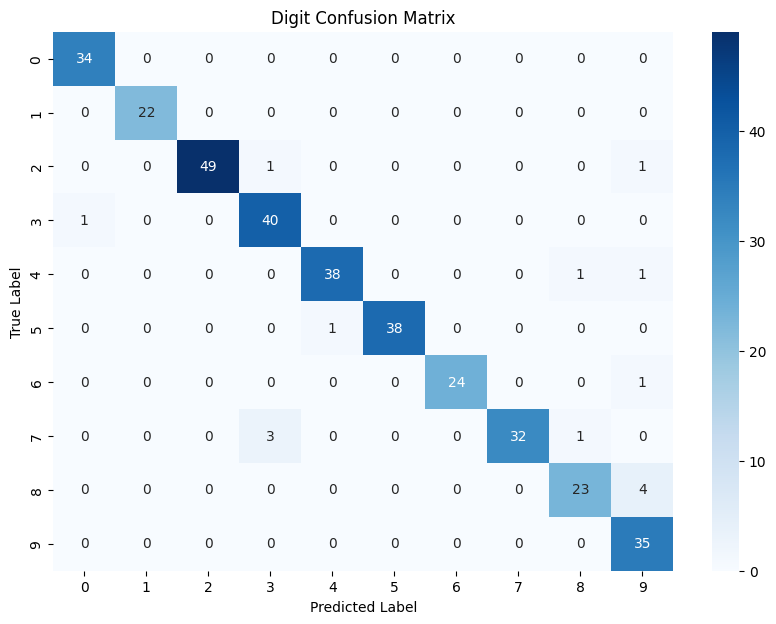

Language - Classification Report:
              precision    recall  f1-score   support

         Eng       1.00      0.99      1.00       174
        Thai       0.99      1.00      1.00       176

    accuracy                           1.00       350
   macro avg       1.00      1.00      1.00       350
weighted avg       1.00      1.00      1.00       350



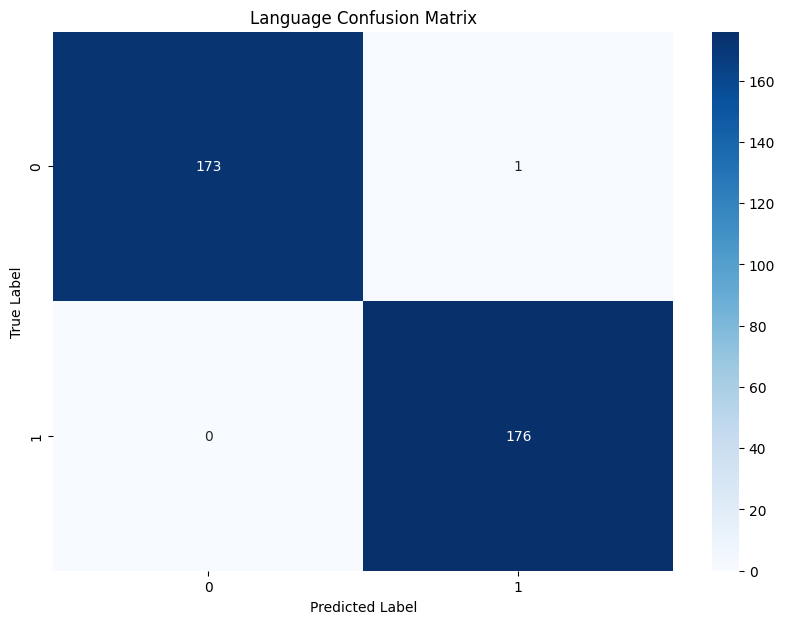

In [29]:
### START CODE HERE ###
def test(model, loss_fn, test_loader, device='cpu'):
    model.to(device)
    print("🔍 Testing on test set...")
    model.eval()
    
    total_test_digit_loss = 0.0
    total_test_lang_loss = 0.0
    total_digit_correct = 0
    total_lang_correct = 0
    total_test_samples = 0
    
    y_true_digit = []
    y_pred_digit = []
    
    y_true_lang = []
    y_pred_lang = []

    with torch.no_grad():
        for images, labels, languages in tqdm(test_loader, desc='🔍 Testing', unit='batch'):
            images, labels, languages = images.to(device), labels.to(device), languages.to(device)

            output_digit, output_lang = model(images)
            
            loss_digit = loss_fn(output_digit, labels)
            loss_lang = loss_fn(output_lang, languages)

            total_test_digit_loss += loss_digit.item()
            total_test_lang_loss += loss_lang.item()

            # Calculate accuracy for digits
            _, pred_digit = torch.max(output_digit, dim=1)
            total_digit_correct += (pred_digit == labels).sum().item()
            
            # Calculate accuracy for languages
            _, pred_lang = torch.max(output_lang, dim=1)
            total_lang_correct += (pred_lang == languages).sum().item()
            
            total_test_samples += labels.size(0)  
            

            y_true_digit.extend(labels.cpu().numpy())
            y_pred_digit.extend(pred_digit.cpu().numpy())

            y_true_lang.extend(languages.cpu().numpy())
            y_pred_lang.extend(pred_lang.cpu().numpy())


    avg_digit_loss = total_test_digit_loss / len(test_loader)
    avg_lang_loss = total_test_lang_loss / len(test_loader)

    # Calculate overall accuracies
    digit_accuracy = total_digit_correct / total_test_samples
    lang_accuracy = total_lang_correct / total_test_samples

    print(f"\nTest Digit Loss: {avg_digit_loss:.4f}, Digit Accuracy: {digit_accuracy:.4f}")
    print(f"Test Language Loss: {avg_lang_loss:.4f}, Language Accuracy: {lang_accuracy:.4f}")

    return (y_true_digit, y_pred_digit), (y_true_lang, y_pred_lang)

model3.load_state_dict(torch.load('multi.pth'))
(y_true_digit, y_pred_digit), (y_true_lang, y_pred_lang) = test(model3, loss_fn, test_loader, device='cuda' if torch.cuda.is_available() else 'cpu')

# digit classification task
evaluate_task(y_true_digit, y_pred_digit, task_name="Digit")

# language classification task
evaluate_task(y_true_lang, y_pred_lang, task_name="Language")
### END CODE HERE ###


---
# Question
1. If you build two separate models, one for each task with a different classification problem, 
how does the overall model size of two separate models compared to a single model with shared layers and two classifiers 
at the end?

2. In what scenarios might a single model with two classifiers outperform two separate models in terms of generalization? Is there a risk of one task negatively affecting the other?

3. How can weighted loss functions be applied in a single model with two classifiers to balance the performance of both tasks?
---
ข้อ 1 
- <b>Two separate model</b> : การสร้างโมเดลแยกสองชุดสำหรับ task แต่ละ task นั้น จะทำให้แต่ละโมเดลมีชุดของ layer และ parameter ของตัวเอง ซึ่งจะทำให้ขนาดของโมเดลมีขนาดใหญ่มากขึ้นเพราะต้องสร้างโมเดลทั้ง2ตัวแยกออกจากกัน โดยแต่ละโมเดลจะทำงานอิสระกัน จึงส่งผลให้มีบาง feature ที่มีการเรียนรู้ที่ซ้ำซ้อนกันในบาง layer

- <b>Single model with mhared layers</b> : การใช้โมเดลเดียวกันที่แชร์ layer สำหรับ feature หลัก แล้วมีตัว classifiers แยกกันในตอนท้ายนั้น จะทำให้ขนาดโมเดลลดลง เนื่องจาก layer ที่ใช้ในการดึง feature นั้นถูกแชร์ร่วมกันระหว่างทั้งสองงาน มีเพียงตัว classifiers เท่านั้นที่แยกกัน โมเดลนี้จึงสามารถลดความซ้ำซ้อนใน layer ที่ใช้ในการดึง feature ได้ และทำให้ขนาดโดยรวมของโมเดลเล็กลงเมื่อเทียบกับการสร้างโมเดลแยกสองชุด
---
ข้อ 2
- positive case : ระบบวิเคราะห์พฤติกรรมลูกค้า (ความพึงพอใจของลูกค้า กับ อัตราการเลิกใช้งานของลูกค้า)
- negative case : จำนวนไก่ในประเทศไทย กับ อัตราการหมุนของโลก
---
ข้อ 3
- หลังจากคำนวณค่า loss สำหรับ task แต่ละ task ได้แล้วนั้น เราสามารถปรับค่า (weights) ที่เหมาะสมกับ task ในแต่ละ task ที่เราสนใจได้ ในการคำนวณ total loss นั้นหาก task ที่ 1 สำคัญกว่า เราสามารถเพิ่มน้ำหนักให้กับ loss ของงานที่ 1 ได้<br>
<b>total_loss = (alpha * loss_task1) + (beta * loss_task2)</b><br>
  - task ที่ 1 มีความสำคัญกว่าอาจจะให้ค่า alpha เท่ากับ 0.7
  - task ที่ 2 มีความสำคัญน้อยกว่าอาจจะให้ค่า beta น้อยกว่า alpha (กำหนดให้ beta = 0.3)
- ในช่วงเริ่มต้น อาจจะตั้งค่าน้ำหนักให้เท่ากันสำหรับ task ทั้ง 2 task แต่สามารถปรับเปลี่ยนได้ระหว่างการ train โมเดล โดยอิงตาม performance metrics เช่น ถ้างานหนึ่งมีความสำคัญหรือยากกว่า เราอาจจะต้องให้ความสำคัญมากขึ้นด้วยการเพิ่ม weight เข้าไป
- การวัดประสิทธิภาพและการปรับความสมดุล
  - การวัดผลลัพธ์ : ใช้ metrics อย่างเช่น accuracy หรือ F1 score สำหรับแต่ละ task เพื่อตรวจสอบผลลัพธ์และปรับค่า weight ตามความเหมาะสม

 - ปรับความสมดุลของค่า weight : หากพบว่า task ใด task หนึ่งได้รับการเรียนรู้น้อยเกินไป เราสามารถเพิ่ม weight ของ task นั้นๆ เพื่อลดปัญหา task imbalance ได้เช่นกัน